In [ ]:
# Load the file dialog
import os
import tkinter as tk
from tkinter import filedialog, OptionMenu, StringVar, Label, Button

# Initialize variables to store the selected paths and patient name
world_video_path = None
world_circle_video_path = None
gaze_pos_path = None
selected_patient = None  # Variable to store the selected patient name

# Function to select the world video file
def select_world_video():
    global world_video_path
    world_video_path = filedialog.askopenfilename(title="Select the world video file", filetypes=[("Video files", "*.mp4")])
    if world_video_path:
        world_video_label.config(text=f"Selected world video: {os.path.basename(world_video_path)}")

# Function to select the world circle video file
def select_world_circle_video():
    global world_circle_video_path
    world_circle_video_path = filedialog.askopenfilename(title="Select the world circle video file", filetypes=[("Video files", "*.mp4")])
    if world_circle_video_path:
        world_circle_video_label.config(text=f"Selected world circle video: {os.path.basename(world_circle_video_path)}")

# Function to select the gaze positions CSV file
def select_csv():
    global gaze_pos_path
    gaze_pos_path = filedialog.askopenfilename(title="Select the gaze positions CSV file", filetypes=[("CSV files", "*.csv")])
    if gaze_pos_path:
        csv_label.config(text=f"Selected CSV: {os.path.basename(gaze_pos_path)}")

# Function to submit and print the selected data
def submit_selection():
    global selected_patient  # Reference the global variable
    if not world_video_path or not world_circle_video_path or not gaze_pos_path:
        result_label.config(text="Please select all required files.")
        print("Submission failed: not all files were selected.")
    else:
        selected_patient = patient_var.get()  # Store the selected patient name
        result_label.config(text=f"Patient: {selected_patient}, World Video: {os.path.basename(world_video_path)}, "
                                 f"World Circle Video: {os.path.basename(world_circle_video_path)}, "
                                 f"CSV: {os.path.basename(gaze_pos_path)}")
        print(f"Submission successful!")
        print(f"Selected patient: {selected_patient}")
        print(f"Selected world video: {world_video_path}")
        print(f"Selected world circle video: {world_circle_video_path}")
        print(f"Selected CSV: {gaze_pos_path}")
        # Close the window after submission
        root.destroy()

# List of patient names

patients = ['1','2','3','4','Deleted due to medical sensitivity']


# Initialize the main window
root = tk.Tk()
root.title("Select Patient, Videos, and CSV")

# Dropdown menu for selecting patient
patient_var = StringVar(root)
patient_var.set(patients[0])  # Default value

Label(root, text="Select Patient:").grid(row=0, column=0)
patient_menu = OptionMenu(root, patient_var, *patients)
patient_menu.grid(row=0, column=1)

# Button to select the world video file
Button(root, text="Choose World Video", command=select_world_video).grid(row=1, column=0, padx=10, pady=10)
world_video_label = Label(root, text="No world video selected")
world_video_label.grid(row=1, column=1)

# Button to select the world circle video file
Button(root, text="Choose World Circle Video", command=select_world_circle_video).grid(row=2, column=0, padx=10, pady=10)
world_circle_video_label = Label(root, text="No world circle video selected")
world_circle_video_label.grid(row=2, column=1)

# Button to select the CSV file
Button(root, text="Choose Gaze Positions CSV", command=select_csv).grid(row=3, column=0, padx=10, pady=10)
csv_label = Label(root, text="No CSV selected")
csv_label.grid(row=3, column=1)

# Button to submit the selection
Button(root, text="Submit", command=submit_selection).grid(row=4, column=0, columnspan=2, pady=20)

# Label to show the result after submission
result_label = Label(root, text="")
result_label.grid(row=5, column=0, columnspan=2)

# Start the main loop
root.mainloop()

if selected_patient[:2] == 'EC':
    segments_file_path = 'Time of segment EC.xlsx'
else:
    segments_file_path = 'Time of segment PD.xlsx'

In [2]:
# Algorithm
import functools
import jax
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
import os

from tapnet import tapir_model
from tapnet.utils import transforms
from tapnet.utils import viz_utils
from tapnet.utils import model_utils

import cv2
from matplotlib.backend_bases import MouseButton
import pandas as pd
import copy
from scipy.spatial.distance import euclidean as eucli

from heatmap_func import *
from tqdm import tqdm
import time

# _________________________________________________TAPIR Model Loading
MODEL_TYPE = 'bootstapir' # 'tapir' or 'bootstapir'
# Load the pre-trained checkpoint
if MODEL_TYPE == 'tapir':
    checkpoint_path = 'tapnet/checkpoints/tapir_checkpoint_panning.npy'
else:
    checkpoint_path = 'tapnet/checkpoints/bootstapir_checkpoint_v2.npy'

# Load the checkpoint state (parameters and model state)
ckpt_state = np.load(checkpoint_path, allow_pickle=True).item()
params, state = ckpt_state['params'], ckpt_state['state']

# Set additional keyword arguments based on the model type
kwargs = dict(bilinear_interp_with_depthwise_conv=False, pyramid_level=0)
if MODEL_TYPE == 'bootstapir':
    kwargs.update(dict(
    pyramid_level=1,
    extra_convs=True,
    softmax_temperature=10.0))

# Initialize the TAPIR model
tapir = tapir_model.ParameterizedTAPIR(params, state, tapir_kwargs=kwargs)


# ____________________________________________________TAPIR Utility Functions

def inference(frames, query_points):
    """Inference on one video.
    Inputs:
    frames: [num_frames, height, width, 3], [0, 255], np.uint8
    query_points: [num_points, 3], [0, num_frames/height/width], [t, y, x]
    Returns:
    tracks: [num_points, 3], [-1, 1], [t, y, x]
    visibles: [num_points, num_frames], bool
    """
    # Preprocess video to match model inputs format
    frames = model_utils.preprocess_frames(frames)
    query_points = query_points.astype(np.float32)
    frames, query_points = frames[None], query_points[None]  # Add batch dimension

    outputs = tapir(video=frames, query_points=query_points, is_training=False, query_chunk_size=32)
    tracks, occlusions, expected_dist = outputs['tracks'], outputs['occlusion'], outputs['expected_dist']

    # Binarize occlusions
    visibles = model_utils.postprocess_occlusions(occlusions, expected_dist)
    return tracks[0], visibles[0]

inference = jax.jit(inference)

resize_height = 128 
resize_width = 128  

def convert_select_points_to_query_points(frame, points):
    """Convert select points to query points.
    Inputs:
    points: [num_points, 2], in [x, y]
    Returns:
    query_points: [num_points, 3], in [t, y, x]
    """
    points = np.stack(points)
    query_points = np.zeros(shape=(points.shape[0], 3), dtype=np.float32)
    query_points[:, 0] = frame
    query_points[:, 1] = points[:, 1]
    query_points[:, 2] = points[:, 0]
    return query_points

# ________________________________________________________ Process the video segment into one frame HeatMap
def FindHeatMap(status, group, id, start_timeSec, end_timeSec, world_path,world_circle_path, gaze_pos_path, second_halfQuery=None, second_halfQueryEnd=None, dynamic=False):
    """
    This function is responsible for generating heatmaps based on gaze data extracted from a video file.

    Inputs:
        - status: The current medical status of the individual (e.g., ON/OFF for PD patients).
        - group: The group the individual belongs to, such as "EC" or "PD".
        - id: The specific identifier of the individual.
        - start_timeSec: The start time of the video segment in seconds.
        - end_timeSec: The end time of the video segment in seconds.
        - world_path: Path to the video that captures the scene from the individual's perspective (world view).
        - world_circle_path: Path to another version of the world video, with the gaze position view.
        - gaze_pos_path: Path to a CSV file that contains gaze positions, with x and y coordinates and a confidence value for each gaze point.
        - second_halfQuery (optional): Query points from the second half of the video to append to the first half's query points for continuous analysis.
        - second_halfQueryEnd (optional): The end time of the second half.
        - dynamic (optional): A flag that, when set to True, will trigger the generation of dynamic heatmaps.
    """

    # Define file paths
    if status:
        patient_info = f'{group}/{id}/{status}'
    else:
        patient_info = f'{group}/{id}'

    # Find frame indices corresponding to start and end times
    cap_world = cv2.VideoCapture(world_path)
    start_time = start_timeSec * 1000                           # Convert to msec units
    end_time = end_timeSec * 1000
    cap_world.set(cv2.CAP_PROP_POS_MSEC, start_time)            # Set the video starting point
    ret, frame = cap_world.read()
    start_frame = int(cap_world.get(cv2.CAP_PROP_POS_FRAMES))   # Get the number of frame of the relevant starting time
    cap_world.set(cv2.CAP_PROP_POS_MSEC, end_time)              # Set video to end time                
    ret, frame = cap_world.read()
    end_frame = int(cap_world.get(cv2.CAP_PROP_POS_FRAMES))     # Get the number of frame of the relevant end time
    height = frame.shape[0]; width = frame.shape[1]             # Get video hight and width

    # Load gaze position data
    gaze_pos = pd.read_csv(gaze_pos_path)
    gaze_pos_conf = gaze_pos[gaze_pos['confidence'] > 0.6]      # get only high confidence points
    gaze_x = gaze_pos_conf['norm_pos_x'] * width                # manipulate normalized x to fit the frames
    gaze_y = (1 - gaze_pos_conf['norm_pos_y']) * height         # manipulate normalized y to fit the frames
    world_idx = gaze_pos_conf['world_index'] 
    time_msec = 1000 * (gaze_pos['gaze_timestamp'] - gaze_pos['gaze_timestamp'][0])

    # Create a list to store frames within the range
    frames = []
    cap_world.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    for i in range(start_frame, end_frame + 1):
        ret, frame = cap_world.read()  # Read the frame
        if ret:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    end_time = int(cap_world.get(cv2.CAP_PROP_POS_MSEC))
    cap_world.release()

    # Calculate frame differences for circular and world views
    cap = cv2.VideoCapture(world_circle_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    ret, frame = cap.read()
    elapsed_time = cap.get(cv2.CAP_PROP_POS_MSEC)
    lower_bound = elapsed_time - 10
    upper_bound = elapsed_time + 10
    # Find the indices where time_msec is within the range
    idx = np.where((time_msec > lower_bound) & (time_msec < upper_bound))[-1]
    frames_diff_circle = gaze_pos.loc[idx[0]]['world_index'] - start_frame 
    cap.release()
    cap = None
    
    # Frames difference calculation on world
    cap_world = cv2.VideoCapture(world_path)
    cap_world.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    ret, frame = cap_world.read()
    elapsed_time = cap_world.get(cv2.CAP_PROP_POS_MSEC)
    lower_bound = elapsed_time - 10
    upper_bound = elapsed_time + 10
    # Find the indices where time_msec is within the range
    idx = np.where((time_msec > lower_bound) & (time_msec < upper_bound))[-1]
    frames_diff_world = gaze_pos.loc[idx[0]]['world_index'] - start_frame 

    frames_diff_world_To_circle = frames_diff_circle - frames_diff_world

    cap_world.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    ret, first_frame = cap_world.read()
    cap_world.release() 
    cap_world = None
    video = media._VideoArray(frames)
    
    # Predict Point Tracks for the Selected Points
    # Rescale video
    resize_height = 128
    resize_width = 128
    frames = media.resize_video(video, (resize_height, resize_width))

    # Define query points from the gaze point file
    query_points = np.array([]).reshape(0, 3)  # Initialize with 0 rows and 3 columns
    is_there_reading = []
    for select_frame in range(len(frames)):
        frame_num = select_frame + start_frame
        eye_reading = world_idx == frame_num + frames_diff_circle  - frames_diff_world_To_circle    # get the relevant world indexes from gaze_pos
        if eye_reading.any():
            Xdot, Ydot = int(np.median(gaze_x[eye_reading])), int(np.median(gaze_y[eye_reading]))   # get the x,y positions from gaze_pos of the dot at the first frame
            select_points = np.array([[select_frame, Ydot, Xdot]])
            is_there_reading.append(True)
        else:
            # No eye reading found; continue to the next frame
            is_there_reading.append(False)
            continue
        query_points = np.append(query_points, select_points, axis=0)

    # In case we are attaching the queries of the second half to the first, in order to analyze the whole video 
    if second_halfQuery is not None:
        last_frame_column = np.ones((len(second_halfQuery), 1)) * (end_frame - start_frame)     # Set the frame number of the attached values as the last frame number of the first half
        second_halfQuery = np.hstack((last_frame_column, second_halfQuery))
        second_halfQuery_C = copy.deepcopy(second_halfQuery)
        second_halfQuery_C[:,1] = second_halfQuery[:,2] # switch x,y
        second_halfQuery_C[:,2] = second_halfQuery[:,1]
        query_points = np.vstack((query_points, second_halfQuery_C))                            # stack the queries of last half over first half 
        end_timeSec = second_halfQueryEnd

    # Convert query points to the appropriate coordinate system
    query_points = transforms.convert_grid_coordinates(
        query_points, (1, height, width), (1, resize_height, resize_width), coordinate_format='tyx')
    print(f'Number of query points / Frames in segment: {len(query_points)} / {end_frame - start_frame}')
    
    if dynamic == True:
        return get_heatmaps(width, height, patient_info, start_timeSec, end_timeSec, status, group, is_there_reading)
    
    pred_save(frames, query_points, width, height, patient_info, start_timeSec, end_timeSec, first_frame, status, group)
    
    
# Process the queries and save them into a file
def pred_save(frames, query_points, width, height, patient_info, start_timeSec, end_timeSec, first_frame, status, group):
    """
    The pred_save function processes video frames and gaze data to generate and save heatmaps and gaze tracking data for a specific video segment.

    Inputs:
        - frames: A list of video frames captured from the specified video segment.
        - query_points: A NumPy array containing the gaze coordinates (x, y positions) across the frames.
        - width: The original width of the video frames.
        - height: The original height of the video frames.
        - patient_info: A string representing details about the patient (e.g., group, ID, status).
        - start_timeSec: The start time of the video segment in seconds.
        - end_timeSec: The end time of the video segment in seconds.
        - first_frame: The first frame of the video segment (used as a reference for visualization).
        - status: The status or condition of the patient during the video recording.
        - group: The patient’s group or category (e.g., "EC" for control group).
    """


    resize_height = 128
    resize_width = 128
    # Predict points using the TAPIR model
    start_time = time.time()
    tracks, visibles = inference(frames, query_points)                          # Process the queries in TAPIR. and get the trackers and visibilities values.
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Finished Tapir in {elapsed_time:.2f} seconds')

    tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))

    # Extract visibility information and trackers only over the first frame of the video
    vis = visibles[:,0] 
    Xdot = tracks[:,0,0]; Ydot = tracks[:,0,1]
    
    directory = os.path.join("Heatmap", patient_info, f"seg{start_timeSec}_{end_timeSec}")
    os.makedirs(directory, exist_ok=True)                                       # Create the directory if it doesn't exist

    # Save gaze data and visibility information
    df = pd.DataFrame({'X': Xdot, 'Y': Ydot})
    df.to_csv(directory + f"/gaze-data.csv", index=False, header=False)

    df = pd.DataFrame({'Visibles': vis})
    df.to_csv(directory + f"/visibles-data.csv", index=False, header=False)
    cv2.imwrite(directory + f"/CleanFirstFrame.png", first_frame)               # Save the first frame with additional text
    
    # Save and create Heatmap
    # Heatmap
    if group == 'EC':
        group = 'OA'
    text = f'Group: {group}, Status: {status}'
    # Define the font and scale
    font = cv2.FONT_HERSHEY_PLAIN
    font_scale = 3; thickness = 5; color = (0, 0, 255); text_position = (10, 100)
    cv2.putText(first_frame, text, text_position, font, font_scale, color, thickness)
    cv2.imwrite(directory + "/text_img.png", first_frame)

    input_path = directory + "/gaze-data.csv"
    display_width = int(width)
    display_height = int(height)
    alpha = 0.5
    output_name = directory
    output_name = output_name + f'/output'
    background_image = directory + "/text_img.png"
    ngaussian = 100
    sd = 5

    with open(input_path) as f:
        reader = csv.reader(f)
        raw = list(reader)
        
        gaza_data = []
        if len(raw[0]) == 2:
                gaze_data = list(map(lambda q: (int(float(q[0])), int(float(q[1])), 1), raw))
        else:
            gaze_data =  list(map(lambda q: (int(q[0]), int(q[1]), int(q[2])), raw))
            
        draw_heatmap(gaze_data, (display_width, display_height), alpha=alpha, savefilename=output_name, imagefile=background_image, gaussianwh=ngaussian, gaussiansd=sd)

In [15]:
# Dynamic Functions

def get_heatmaps(width, height, patient_info, start_timeSec, end_timeSec, status, group, is_there_reading):
    """
    This function generates dynamic heatmaps based on gaze data for each frame of a video segment. The heatmaps visualize
    where the gaze points are concentrated over time, using Gaussian smoothing to highlight areas of interest. 
    Inputs:
    - width: The original width of the video frames, used to define the size of the heatmap.
    - height: The original height of the video frames, used to scale the heatmap.
    - patient_info: A string containing patient details (group, ID, status), used to create output directories.
    - start_timeSec: The start time of the video segment in seconds, used for labeling the heatmap and directory.
    - end_timeSec: The end time of the video segment in seconds, used for labeling the heatmap and directory.
    - status: The status of the patient (e.g., ON, OFF), used in text displayed on the heatmap.
    - group: The patient’s group (e.g., EC, PD), used for labeling and grouping files.
    - is_there_reading: A list indicating whether valid gaze data exists for each frame, used to decide when to create a heatmap.
    """
        
    # Create output directory
    patient_name = patient_info.split('/')[-1]
    directory = os.path.join("Heatmap", group, patient_name,f"seg{start_timeSec}_{end_timeSec}")
    os.makedirs(directory, exist_ok=True)  # Create the directory if it doesn't exist
    
    # Heatmap
    if group == 'EC':
        group = 'OA'
    text = f'Group: {group}, Status: {status}'

    gaze_data_path = directory + "\\gaze-data.csv"
    vis_data_path = directory + "\\visibles-data.csv"
    display_width = int(width)
    display_height = int(height)
    alpha = 0.5
    # start_timeSec = str.replace(str(start_timeSec),'.', '_')

    background_image = directory + "\\text_img.png"
    ngaussian = 100
    sd = 5
    
    with open(gaze_data_path) as f:
        reader = csv.reader(f)
        raw = list(reader)
    
    visibility = pd.read_csv(vis_data_path,header=None)

    gaze_data = []
    if len(raw[0]) == 2:
        gaze_data = list(map(lambda q: (int(float(q[0])), int(float(q[1])), 1), raw))
    else:
        gaze_data =  list(map(lambda q: (int(q[0]), int(q[1]), int(q[2])), raw))
    
    heatmaps = np.zeros((len(is_there_reading), display_height, display_width, 3), dtype=np.uint8)
    NFalse = 0
    for i in range(len(is_there_reading)):
        if is_there_reading[i] and visibility.values[i - NFalse]: # incase confidence was okay and visibility vector is okay 
        # if is_there_reading[i]:
            fig = draw_heatmap(gaze_data[:i - NFalse], (display_width, display_height), alpha=alpha, imagefile=background_image, gaussianwh=ngaussian, gaussiansd=sd, dynamic=1)
            fig.canvas.draw()

            # Now we can save it to a numpy array.
            data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            heatmaps[i,:,:,:] = data
            pyplot.close(fig)
        
        elif is_there_reading[i] == False:
            NFalse += 1
            heatmaps[i,:,:,:] = data

        else:
            heatmaps[i,:,:,:] = data
     
    return heatmaps
    

def save_video(frames, filename, fps=5):
    """
    This function saves a list of video frames as an output video file.
    Inputs:
        - frames: A list of video frames (each frame is a NumPy array).
        - filename: The name of the file where the video will be saved (including the file extension, e.g., 'output.mp4').
        - fps: Frames per second (default is 5).
    """

    # Get the dimensions from the first frame
    height, width, _ = frames[0].shape
    
    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID' for .avi files
    video_writer = cv2.VideoWriter(filename, fourcc, fps, (width, height))
    
    for frame in frames:
        # Convert RGB to BGR (since OpenCV uses BGR format)
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        video_writer.write(frame_bgr)
    
    # Release the VideoWriter object
    video_writer.release()
    print(f"Video saved as {filename}")


def save_combined_video(video_path2, start_time_sec, output_filename, fps=5):
    """
    This function combines two video files side by side and saves the combined video.
    Inputs:
        - video_path2: Path to the second video file that starts at a specific time.
        - start_time_sec: The starting time (in seconds) for the second video.
        - output_filename: The name of the output file for the combined video.
        - fps: Frames per second (default is 5).
    """

    video_path1 = 'output_video.mp4'
    # Open the first video
    cap1 = cv2.VideoCapture(video_path1)
    if not cap1.isOpened():
        print(f"Error opening video file {video_path1}")
        return

    # Open the second video
    cap2 = cv2.VideoCapture(video_path2)
    if not cap2.isOpened():
        print(f"Error opening video file {video_path2}")
        return

    # Get frame properties from the first video
    frame_width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID' for .avi files
    video_writer = cv2.VideoWriter(output_filename, fourcc, fps, (frame_width * 2, frame_height))
    
    # Calculate the start frame for the second video
    fps2 = cap2.get(cv2.CAP_PROP_FPS)
    start_frame2 = int(start_time_sec * fps2)

    # Set the frame position for the second video
    cap2.set(cv2.CAP_PROP_POS_MSEC, start_time_sec*1000)
    
    while True:
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        
        # Break the loop if either video ends
        if not ret1 or not ret2:
            break

        # Resize frames to match
        if frame1.shape[:2] != frame2.shape[:2]:
            frame2 = cv2.resize(frame2, (frame1.shape[1], frame1.shape[0]))

        # Stack frames side by side
        combined_frame = np.hstack((frame1, frame2))
        
        # Write the combined frame to the video file
        video_writer.write(combined_frame)
        
    # Release video captures and VideoWriter, and close windows
    cap1.release()
    cap2.release()
    video_writer.release()
    cv2.destroyAllWindows()
    print(f"Combined video saved as {output_filename}")
    os.remove('output_video.mp4')

In [6]:
# Get segments times split
def start_process():
    sheet = selected_patient                                                # From segments CSV file, select te patient's sheet
    segments = pd.read_excel(segments_file_path, sheet_name=sheet)  
    return segments, sheet

segments, sheet = start_process()                                           # Get the segments info, and the patients name


## Find specific Heatmaps

In [22]:
# Process second half of video
segment_num = 2                                                             # Choose the segment to analyze
try:
    group = sheet[:2]; id = sheet[:10];  status = sheet[11:]
    times = segments[segments['SEGMENT'] == segment_num]['time_sec']        # Get start and end time of segment    
    start = times.iloc[0]; end = times.iloc[1]; half = (start + end) / 2    # Define the star, half and end times of walking segment
    # Process the segment's relevant times
    start_analyze = half; end_analyze = end-4                               # Define times to analyze
    # FindHeatMap(status, group, id, start_analyze, end_analyze, world_video_path, world_circle_video_path, gaze_pos_path, second_halfQuery=None)

    second_half_end = end_analyze
except Exception as e:
    print(e)


In [23]:
# Load the second half processed data after it was analyzed in the last cell
if status:
    patient_info = f'{group}/{id}/{status}'
else:
    patient_info = f'{group}/{id}'

directory = os.path.join("Heatmap", patient_info, f"seg{start_analyze}_{end_analyze}",'gaze-data.csv' )
query_SecondHalf = pd.read_csv(directory)
query_SecondHalf = np.array(query_SecondHalf)

Number of query points / Frames in segment: 49 / 1
Finished Tapir in 3.54 seconds


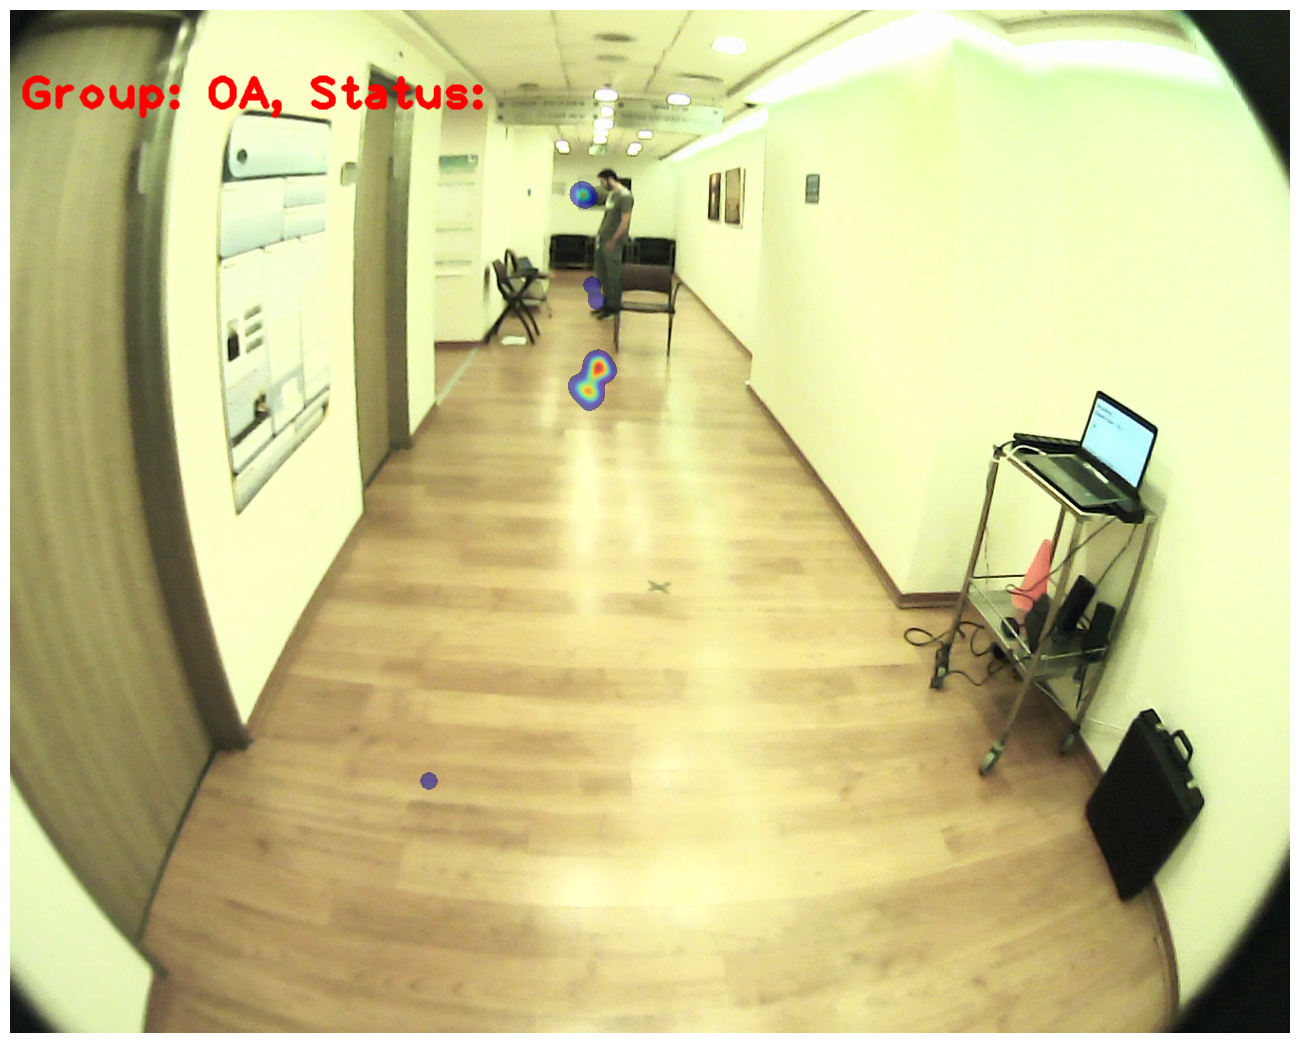

In [24]:
# Attach the second half to the first half and process as whole
try:
    group = sheet[:2]; id = sheet[:10];  status = sheet[11:]
    times = segments[segments['SEGMENT'] == segment_num]['time_sec']
    start = times.iloc[0]; end = times.iloc[1]; half = (start + end) / 2
    start_analyze = start+6; end_analyze = half                                # Define times to analyze
    FindHeatMap(status, group, id, start_analyze, end_analyze, world_video_path, world_circle_video_path, gaze_pos_path, second_halfQuery=query_SecondHalf, second_halfQueryEnd=second_half_end)

except Exception as e:
    print(e)

## Dynamic Heatmaps

In [ ]:
# Dynamic
segment_num = 2                                                             # Choose the segment to analyze
try:
    group = sheet[:2]; id = sheet[:10];  status = sheet[11:]
    times = segments[segments['SEGMENT'] == segment_num]['time_sec']        # Get start and end time of segment    
    start = times.iloc[0]; end = times.iloc[1]; half = (start + end) / 2    # Define the star, half and end times of walking segment
    # Process the segment's relevant times
    start_analyze = start+6; end_analyze = end-4               
    heatmaps = FindHeatMap(status, group, id, start_analyze, end_analyze, world_video_path, world_circle_video_path, gaze_pos_path, second_halfQuery=None, dynamic=True)
except Exception as e:
    print(e)

save_video(heatmaps, 'output_video.mp4', 5)

# Output file path
output_filename = filedialog.askdirectory(title="Where to drop the dynamic heat map?",
) + f'/DynamicHeatMap_{id}_{status}_{start_analyze}-{end_analyze}.mp4'

save_combined_video(world_circle_video_path, start_time_sec=start_analyze, output_filename=output_filename)